In [1]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import boxcox
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import  roc_auc_score, classification_report, accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import classification_report
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from sklearn.feature_selection import f_classif,SelectKBest
import warnings
warnings.filterwarnings('ignore')

In [59]:
def detect_cusum(x, threshold=1, drift=0, ending=False, show=True, ax=None):
    x = np.atleast_1d(x).astype('float64')
    gp, gn = np.zeros(x.size), np.zeros(x.size)
    ta, tai, taf = np.array([[], [], []], dtype=int)
    tap, tan = 0, 0
    amp = np.array([])
    # Find changes (online form)
    for i in range(1, x.size):
        s = x[i] - x[i-1]
        gp[i] = gp[i-1] + s - drift  # cumulative sum for + change
        gn[i] = gn[i-1] - s - drift  # cumulative sum for - change
        if gp[i] < 0:
            gp[i], tap = 0, i
        if gn[i] < 0:
            gn[i], tan = 0, i
        if gp[i] > threshold or gn[i] > threshold:  # change detected!
            ta = np.append(ta, i)    # alarm index
            tai = np.append(tai, tap if gp[i] > threshold else tan)  # start
            gp[i], gn[i] = 0, 0      # reset alarm
    # THE CLASSICAL CUSUM ALGORITHM ENDS HERE

    # Estimation of when the change ends (offline form)
    if tai.size and ending:
        _, tai2, _, _ = detect_cusum(x[::-1], threshold, drift, show=False)
        taf = x.size - tai2[::-1] - 1
        # Eliminate repeated changes, changes that have the same beginning
        tai, ind = np.unique(tai, return_index=True)
        ta = ta[ind]
        # taf = np.unique(taf, return_index=False)  # corect later
        if tai.size != taf.size:
            if tai.size < taf.size:
                taf = taf[[np.argmax(taf >= i) for i in ta]]
            else:
                ind = [np.argmax(i >= ta[::-1])-1 for i in taf]
                ta = ta[ind]
                tai = tai[ind]
        # Delete intercalated changes (the ending of the change is after
        # the beginning of the next change)
        ind = taf[:-1] - tai[1:] > 0
        if ind.any():
            ta = ta[~np.append(False, ind)]
            tai = tai[~np.append(False, ind)]
            taf = taf[~np.append(ind, False)]
        # Amplitude of changes
        amp = x[taf] - x[tai]

    if show:
        _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn)

    return ta, tai, taf, amp


def _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn):
    """Plot results of the detect_cusum function, see its help."""

    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

        t = range(x.size)
        ax1.plot(t, x, 'b-', lw=2)
        if len(ta):
            ax1.plot(tai, x[tai], '>', mfc='g', mec='g', ms=10,
                     label='Start')
            if ending:
                ax1.plot(taf, x[taf], '<', mfc='g', mec='g', ms=10,
                         label='Ending')
            ax1.plot(ta, x[ta], 'o', mfc='r', mec='r', mew=1, ms=5,
                     label='Alarm')
            ax1.legend(loc='best', framealpha=.5, numpoints=1)
        ax1.set_xlim(-.01*x.size, x.size*1.01-1)
        ax1.set_xlabel('Data #', fontsize=14)
        ax1.set_ylabel('Amplitude', fontsize=14)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax1.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax1.set_title('Time series and detected changes ' +
                      '(threshold= %.3g, drift= %.3g): N changes = %d'
                      % (threshold, drift, len(tai)))
        ax2.plot(t, gp, 'y-', label='+')
        ax2.plot(t, gn, 'm-', label='-')
        ax2.set_xlim(-.01*x.size, x.size*1.01-1)
        ax2.set_xlabel('Data #', fontsize=14)
        ax2.set_ylim(-0.01*threshold, 1.1*threshold)
        ax2.axhline(threshold, color='r')
        ax1.set_ylabel('Amplitude', fontsize=14)
        ax2.set_title('Time series of the cumulative sums of ' +
                      'positive and negative changes')
        ax2.legend(loc='best', framealpha=.5, numpoints=1)
        plt.tight_layout()
        plt.savefig('cosum.jpg', dpi=500)
        plt.show()

In [50]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Time Series Plot')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

In [4]:
data=pd.read_csv('train_mutual_info.csv')

In [5]:
data=data.fillna(0)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22232 entries, 0 to 22231
Data columns (total 16 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Потенциальный дебит жидкости, м3/сут        22232 non-null  float64
 1   Забойное давление                           22232 non-null  float64
 2   Потенциальный дебит нефти, т/сут            22232 non-null  float64
 3   Пласт1/Добыча жидкости м3/сут               22232 non-null  float64
 4   Целевое забойное давление                   22232 non-null  float64
 5   Свободный газ на входе при подаче Q опт, %  22232 non-null  float64
 6   ЗамерыМРМ/Дебит жидкости (ТМ)               22232 non-null  float64
 7   ЗамерыМРМ/Дебит нефти (ТМ)                  22232 non-null  float64
 8   ЗамерыМРМ/Обводненность (ТМ)                22232 non-null  float64
 9   ЗамерыМРМ/Дебит газа (ТМ)                   22232 non-null  float64
 10  ЗамерыМРМ/

In [7]:
X=data.drop(['Failure'],axis=1)

In [52]:
series=data['ЗамерыМРМ/Дебит жидкости (ТМ)']

In [53]:
series.isna().any()

False

In [54]:
series=series.interpolate('nearest')
series=series.fillna(0)

In [55]:
series

0        137.0
1        136.0
2        137.0
3        137.0
4        136.0
         ...  
22227     26.0
22228     26.0
22229     28.0
22230     28.0
22231     27.0
Name: ЗамерыМРМ/Дебит жидкости (ТМ), Length: 22232, dtype: float64

In [56]:
min_value = data['ЗамерыМРМ/Дебит жидкости (ТМ)'].min()
print("Minimum value: ", min_value)

Minimum value:  0.0


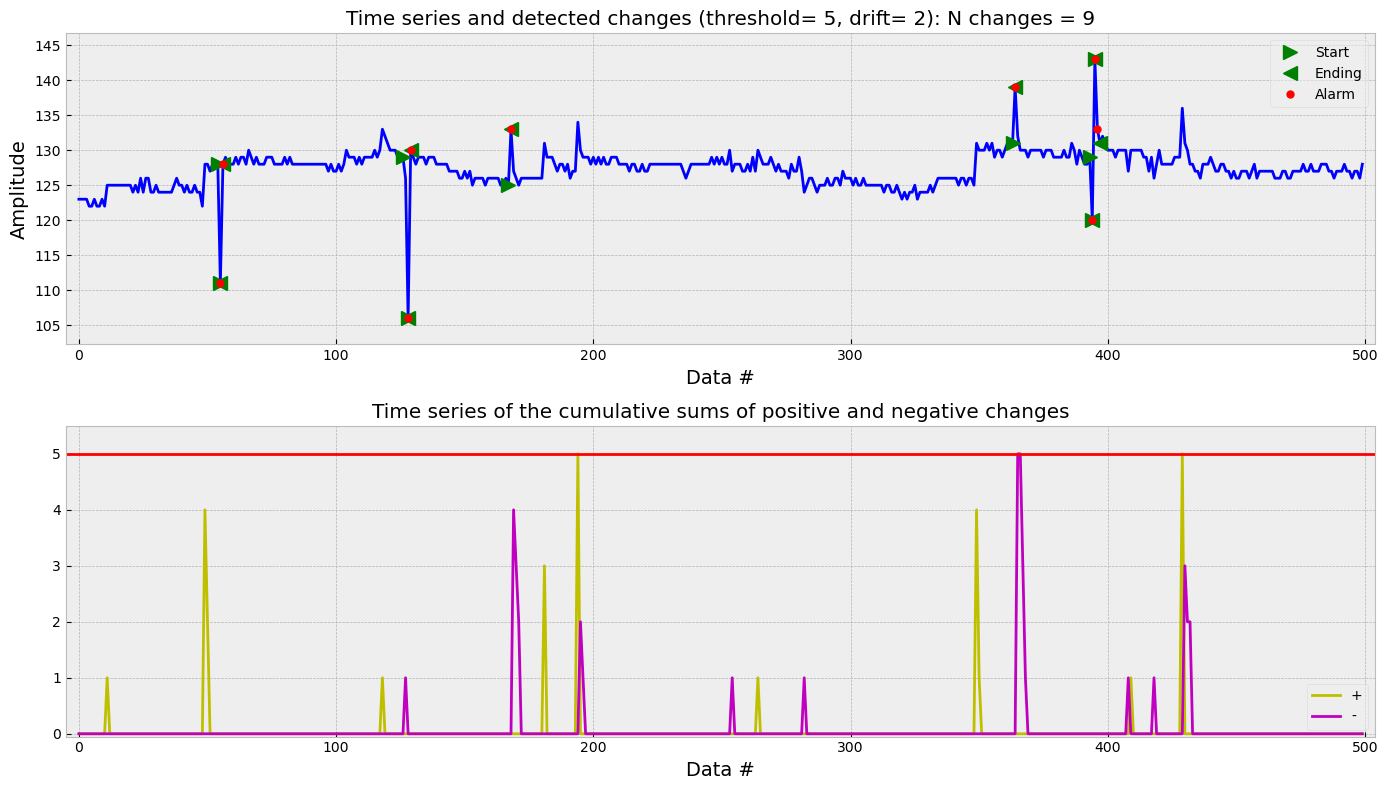

In [60]:
ta, tai, taf, amp = detect_cusum(series[400:900], 5, 2, True, True)

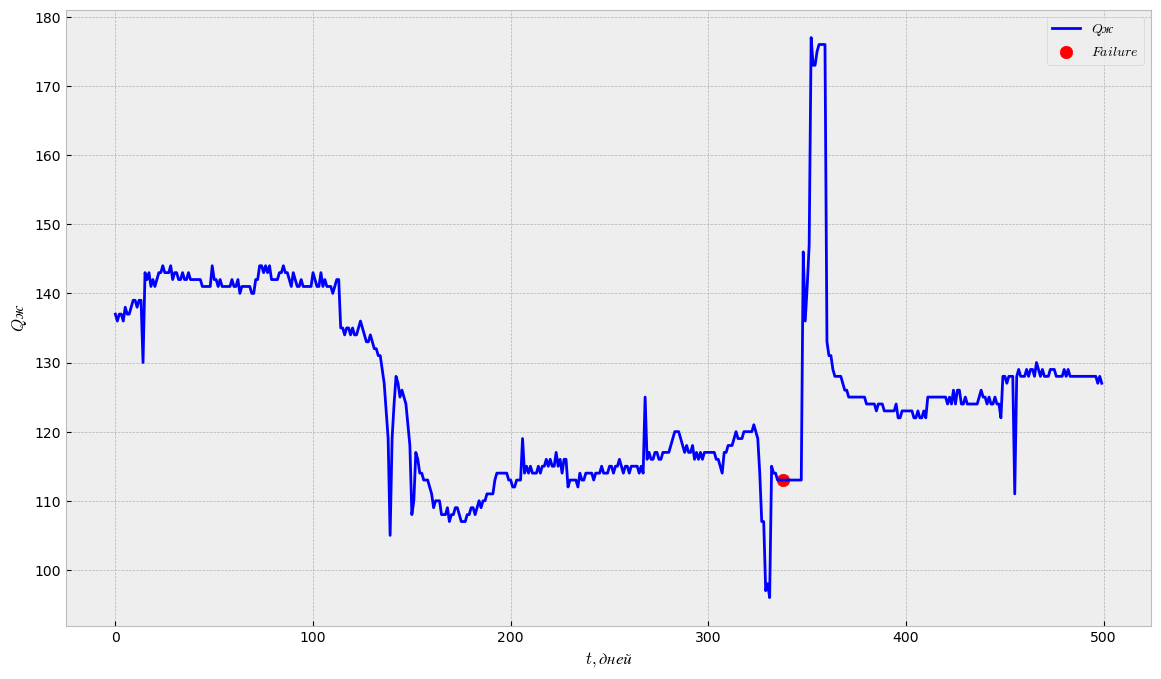

In [44]:
plt.figure(figsize=(14,8))
plt.style.use('bmh')
plt.plot(series[0:500], c='blue', label='$Q ж$')
plt.scatter(338, series[338], c='red', s=80, label='$Failure$')
plt.legend()
plt.ylabel(r'$Q ж$')
plt.xlabel('$t, дней$')
plt.savefig('LiquidRatePot_m3_d_original(zoom).jpg', dpi=500 );

In [45]:
series = boxcox(series, 0)

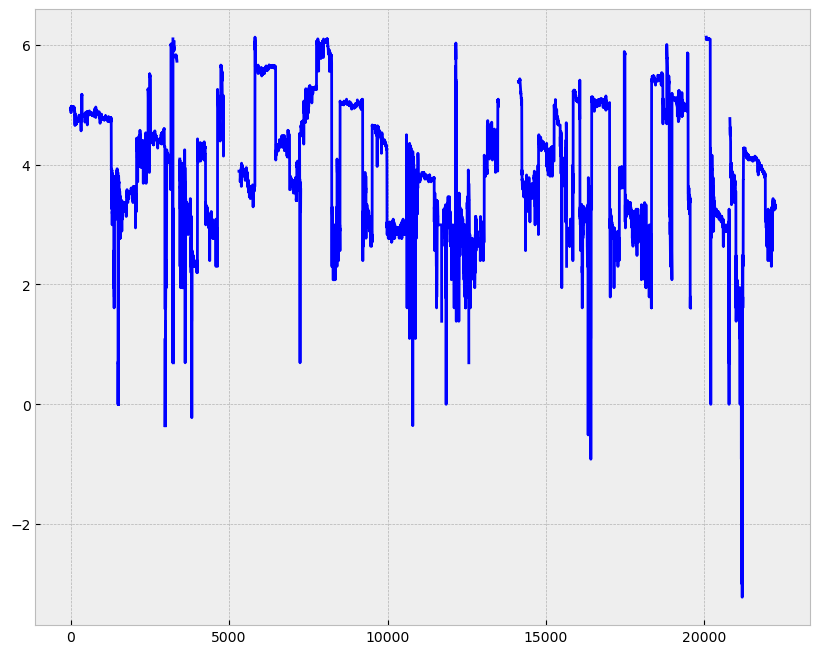

In [46]:
plt.figure(figsize=(10,8))
plt.style.use('bmh')
plt.plot(series, c='blue');